In [ ]:
! pip install langchain-anthropic langgraph

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

## Workflow

Now, let's put this all together into a [workflow](https://langchain-ai.github.io/langgraph/tutorials/workflows/). 

In the workflow, we'll simply use routing to determine the control flow.

This make it very simple, and even amenable to local models if you choose to run this journal privately. 

![Memory Course App](./img/memory_course_app.png)

In [17]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain_anthropic import ChatAnthropic

# Schema for user profile
class Router(BaseModel):
    classification: Literal["search", "extract", "update_instructions","update_examples"] = Field(None, description="The classification of the user's request to search, extract, update instructions, or update examples, or update examples")

# Define and augment LLM with structured output
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
llm_router = llm.with_structured_output(Router)

In [35]:
import sys
sys.path.append('..')
import src.memory_course.prompts
import src.memory_course.examples
import src.memory_course.utils

# Reload the module in case any changes were made
import importlib
importlib.reload(src.memory_course.prompts)
importlib.reload(src.memory_course.examples)
importlib.reload(src.memory_course.utils)
importlib.reload(src.memory_course.state)

# Then import the instructions and examples
from src.memory_course.state import Memory, Memories, State, UserProfile, MemorySearch, Example, Examples
from src.memory_course.utils import format_few_shot_examples
from src.memory_course.examples import example_input, example_output
from src.memory_course.prompts import memory_collection_extraction_instructions, update_memory_collection_extraction_instructions, update_few_shot_examples_instructions, collection_extraction_input, profile_extraction_input, memory_search_instructions, memory_profile_extraction_instructions, routing_instructions

In [36]:
from langchain_core.messages import SystemMessage, HumanMessage

def route_user_request(user_input: str) -> Router:
    """  Route the user request to the appropriate tool based on intent analysis.
        
    Args:
        user_input (str): The raw text input from the user describing their request
            Examples:
            - "I want to search for a memory"
            - "Add this to my journal"
            - "Update my profile"
            
    Returns:
        Router: An enum indicating which tool or action should handle the request """
    next_step = llm_router.invoke([SystemMessage(content=routing_instructions), HumanMessage(content=f"<User Input>{user_input}</User Input>")])
    return next_step.classification


Now, test a few inputs.

In [37]:
# Test each routing case
print("Case 1:", route_user_request("When saving ideas dont include Required or Prerequisites."))
# Should return Router.UPDATE_INSTRUCTIONS
# Because this is a general rule about how to extract/format ideas

print("Case 2:", route_user_request("Let's re-write the memory docs to make them more clear is a ToDo."))
# Should return Router.UPDATE_EXAMPLES
# Because this is showing how to classify a specific type of entry as a TODO

print("Case 3:", route_user_request("Today I went finished the memory course and went out to eat at a new restaurant."))
# Should return Router.EXTRACT
# Because this is a new journal entry that needs processing

print("Case 4:", route_user_request("Tell me my ToDos"))
# Should return Router.SEARCH
# Because this is requesting to retrieve existing memories from the TODO collection

Case 1: update_instructions
Case 2: update_examples
Case 3: extract
Case 4: search


Now, define the workflow.

In [38]:
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")

Populate the store with baseline instructions and examples

TODO: Will come through config in final app, but will be updated programmatically via interactions 
 

In [39]:
# Save baseline instructions to the store
from datetime import datetime
from langgraph.store.memory import InMemoryStore

in_memory_store = InMemoryStore()
namespace = ("journal","instructions")
key = "instructions_extraction"
in_memory_store.put(namespace, key, {"instructions": memory_collection_extraction_instructions})

namespace = ("journal","examples")
key = f"example_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
in_memory_store.put(namespace, key, {"input": example_input, "output": example_output})

Nodes and edges of the graph

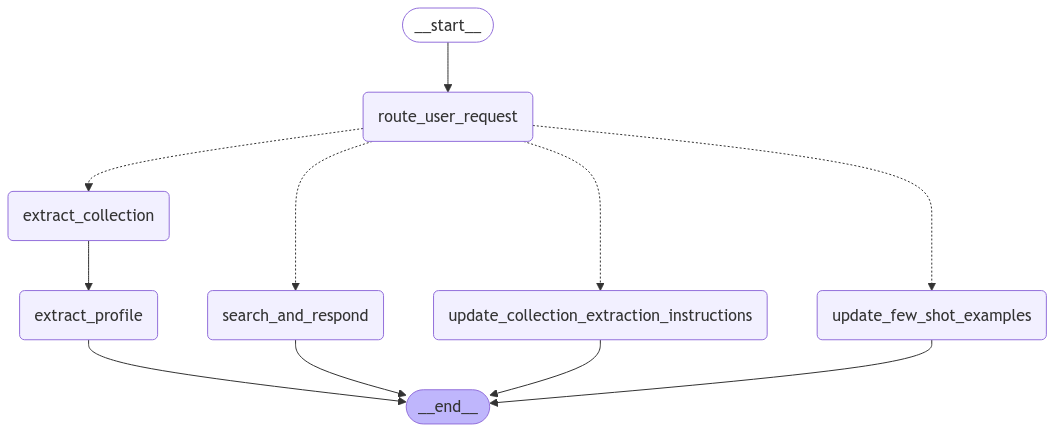

In [43]:
import uuid
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.store.base import BaseStore

# Nodes
def extract_collection(state: State, store: BaseStore) -> dict:
    """Extract memories from a journal entry and store them in the memory store.
    
    Args:
        state (dict): Graph state
        
    Returns:
        Dict: Update journal output"""

    # Get the instructions from the store
    namespace = ("journal","instructions")
    key = "instructions_extraction"
    instructions = store.get(namespace, key)

    # Get the examples from the store
    few_shot_examples = store.search(("journal", "examples"))
    few_shot_examples_formatted = format_few_shot_examples(few_shot_examples)

    # Format the instructions
    memory_extraction_instructions_formatted = collection_extraction_input.format(
        procedural_memory_instructions=instructions.value['instructions'],
        few_shot_examples_formatted=few_shot_examples_formatted
    )

    # Extract memories
    structured_llm = llm.with_structured_output(Memories)
    memories = structured_llm.invoke([SystemMessage(content=memory_extraction_instructions_formatted),
                                      HumanMessage(content=f"Extract memory from <context> {state['user_input']} </context>")])
    
    # Iterate through each memory and store in appropriate collection
    for memory in memories.memories:

        # Generate a unique UUID for each memory
        memory_id = str(uuid.uuid4())
        
        # Create namespace tuple with the specific collection type (memory_type)
        namespace = ("journal", "memory", "collection", memory.memory_type.lower())
        
        # Create the key using the UUID
        key = f"memory_{memory_id}"
        
        # Create the value object according to the schema
        value = {
            "memory": memory.memory_content,  #
            "timestamp": datetime.now().isoformat(),
        }
        
        # Store in the database
        store.put(namespace, key, value)

    return {"journal_output": "I've updated the memory collection!"}

def extract_profile(state: State, store: BaseStore) -> dict:
    """Extract a profile from a journal entry and store it in the memory store.
    
    Args:
        state (dict): Graph state
        
    Returns:
        Dict: Update journal output"""
    
    # Get instructions
    memory_profile_extraction_instructions = store.get(("journal","instructions"), "instructions_profile_extraction")

    # Get existing profile
    namespace = ("journal", "memory", "profile")
    key = "profile"
    profile = in_memory_store.get(namespace, key)

    # Format input
    input = profile_extraction_input.format(
        memory_profile_extraction_instructions=memory_profile_extraction_instructions,
        profile=profile,
        journal_entry=state['user_input']
    )

    # Run extraction
    structured_llm = llm.with_structured_output(UserProfile)
    profile = structured_llm.invoke(input)

    # Iterate through each memory and store in appropriate collection
    namespace = ("journal", "memory", "profile")
    key = "profile"
    value = profile
    store.put(namespace, key, value)

    return {"journal_output": "I've updated the user profile based upon your feedback!"}

def update_collection_extraction_instructions(state: State, store: BaseStore) -> str:
    """Update instructions for memory collection extraction based on user feedback.
        
    Args:
        user_feedback (str): User feedback about the memory extraction process
        
    Returns:
        Dict: Update journal output"""

    # Get the current instructions
    namespace = ("journal","instructions")
    key = "instructions_extraction"
    instructions = store.get(namespace, key)

    # Extract memories
    updated_instructions = llm.invoke([SystemMessage(content=update_memory_collection_extraction_instructions.format(instructions=instructions.value['instructions'])),
                                            HumanMessage(content=f"<Feedback> {state['user_input']} </Feedback>")])
    
    # Add the new instructions to the store
    store.put(namespace, key, {"instructions": updated_instructions.content})

    return {"journal_output": "I've updated instructions for memory collection extraction based upon your feedback!"}

def update_few_shot_examples(user_feedback: str, store: BaseStore) -> str:
    """Few shot examples can be updated based on user feedback.
        
    Args:
        user_feedback (str): User feedback about the memory extraction process
        
    Returns:
        Dict: Update journal output"""

    # Get the examples from the store
    namespace = ("journal","examples")
    few_shot_examples = store.search(namespace)
    few_shot_examples_formatted = format_few_shot_examples(few_shot_examples)

    # Create new few shot examples from the user feedback
    structured_llm = llm.with_structured_output(Examples)
    updated_few_shot_examples = structured_llm.invoke([SystemMessage(content=update_few_shot_examples_instructions.format(current_examples=few_shot_examples_formatted)),
                                            HumanMessage(content=f"<Feedback> {user_feedback} </Feedback>")])
    
    # Add the new few shot examples to the store
    for example in updated_few_shot_examples.examples:
        key = f"example_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        store.put(namespace, key, {"input": example.example_input, "output": example.example_output})

    return {"journal_output": "I've updated my examples based upon your feedback!"}

def search_and_respond(state: State, store: BaseStore):
    """Search and retrieve relevant memories from the appropriate collection based on user input.
    
    This function performs several steps:
    1. Identifies available memory collections (sentiment, todo, idea)
    2. Determines which collection to search based on user's query
    3. Retrieves and sorts memories from the chosen collection
    4. Formats the collection for readability
    5. Generates a natural language response addressing the user's query
    
    Args:
        user_input (str): The user's search query or question about their memories
            Examples:
            - "What tasks do I need to complete?"
            - "How was I feeling last week?"
            - "What ideas did I have about the project?"
    
    Returns:
        dict: A dictionary containing:
            - journal_output (str): A natural language response addressing the
              user's query based on the retrieved memories"""

    # Get the last element of each namespace tuple which represents the collection type
    namespace = ("journal", "memory", "collection")
    all_memories = store.search(namespace)
    unique_collections = sorted({item.namespace[-1] for item in all_memories})

    # Format the prompt
    structured_llm = llm.with_structured_output(MemorySearch)
    search_instructions_formatted = memory_search_instructions.format(available_collections=unique_collections,  
                                                               memory_classification_prompt=memory_collection_extraction_instructions)
    # Get the collection to search
    collection = structured_llm.invoke([SystemMessage(content=search_instructions_formatted), HumanMessage(content=f"<User Input>{state['user_input']}</User Input>")])
    collection_type = collection.collection

    # Get the collection from the memory store
    collection = store.search(("journal", "semantic", "collection", collection_type))

    # Sort items by creation timestamp
    sorted_items = sorted(collection, key=lambda x: x.created_at)
    
    # Extract memory collection contents
    memories = []
    for item in sorted_items:
        if isinstance(item.value.get('memory'), Memory):
            memories.append(item.value['memory'].memory_content)
        else:
            memories.append(item.value.get('memory'))
    
    # Format the collection output as a string for LLM 
    output = [
        f"Collection Type: {collection_type.upper()}",
        "Sorted by: Creation Time (Oldest to Newest)",
        "\nItems:",
        *[f"• {memory}" for memory in memories]
    ]
    formatted_collection = "\n".join(output)

    # Get the profile for general context
    namespace = ("journal", "memory", "profile")
    key = "profile"
    profile = store.get(namespace, key)

    # Get the response
    response = llm.invoke(SystemMessage(content=f"Here is a relevant memory collection <Memory Collection>{formatted_collection}</Memory Collection> and a general profile of the user <User Profile>{profile}</User Profile>"), 
                          HumanMessage(content=f"Use the collection to address the user request: <User Input>{state['user_input']}</User Input>"))
    
    return {"journal_output": response.content}

def route_user_request(state: State) -> str:
    """  Route the user request to the appropriate tool based on intent analysis.
        
    Args:
        user_input (str): The raw text input from the user describing their request
            Examples:
            - "I want to search for a memory"
            - "Add this to my journal"
            - "Update my profile"
            
    Returns:
        str: Tool or action should handle the request """
    
    # Run the router
    next_step = llm_router.invoke([SystemMessage(content=routing_instructions), 
                                   HumanMessage(content=f"<User Input>{state['user_input']}</User Input>")])
    
    return {"routing_decision": next_step.classification}

def route_decision(state: State):
    """Route the workflow to the next appropriate node based on the routing decision.
    
    This is a conditional edge function that determines which node should process
    the request next in the workflow graph. It uses the routing_decision from the
    state to select the appropriate processing path.
    
    Args:
        state (State): The current workflow state containing:
            - routing_decision (str): One of:
                - "search": Find existing memories
                - "extract": Process new journal entry
                - "update_instructions": Modify extraction rules
                - "update_examples": Update classification patterns
            
    Returns:
        str: Name of the next node to execute:
            - "search_memories": Handle memory retrieval
            - "extract_memories": Process new entries
            - "update_extraction_rules": Modify extraction behavior
            - "update_classification_rules": Update classification rules
            
    Raises:
        ValueError: If routing_decision is not one of the expected values"""
    
    if state["routing_decision"] == "search":
        return "search_and_respond"
    elif state["routing_decision"] == "extract":
        return "extract_collection"
    elif state["routing_decision"] == "update_instructions":
        return "update_collection_extraction_instructions"
    elif state["routing_decision"] == "update_examples":
        return "update_few_shot_examples"
    else:
        raise ValueError(f"Unknown decision type: {state['decision']}")

# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("extract_collection", extract_collection)
router_builder.add_node("extract_profile", extract_profile)
router_builder.add_node("update_few_shot_examples", update_few_shot_examples)
router_builder.add_node("update_collection_extraction_instructions", update_collection_extraction_instructions)
router_builder.add_node("search_and_respond", search_and_respond)
router_builder.add_node("route_user_request", route_user_request)

# Add edges to connect nodes
router_builder.add_edge(START, "route_user_request")
router_builder.add_conditional_edges(
    "route_user_request",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "search_and_respond": "search_and_respond",
        "extract_collection": "extract_collection",
        "update_collection_extraction_instructions": "update_collection_extraction_instructions",
        "update_few_shot_examples": "update_few_shot_examples",
    },
)
router_builder.add_edge("search_and_respond", END)
router_builder.add_edge("extract_collection", "extract_profile")
router_builder.add_edge("extract_profile", END)
router_builder.add_edge("update_collection_extraction_instructions", END)
router_builder.add_edge("update_few_shot_examples", END)

# Compile workflow
router_workflow = router_builder.compile(store=in_memory_store)

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [ ]:
# TODO Test 